# Parking Ticket Predictions

This project is based on a data challenge from Michigan Data Science Team (MDST). 

The Michigan Data Science Team (MDST) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences (MSSISS) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - building deterioration. Blight violations are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

Our data comes from the Detroit Open Data Portal (https://data.detroitmi.gov/) and comes with two files: past_blight_tickets.csv and current_blight_tickets.csv. 

The first step in increasing blight ticket payment compliance is to better understand common indicators of when and why citizens do not pay their ticket fees. To do this, we will build a few supervised learning models to take a deeper look at the commonalities that people who do or don't pay their blight fees.   

The **files** include:

    past_blight_tickets.csv - training set of tickets issued 2004-2011
    current_blight_tickets.csv = the test set of all blight tickets issued 2012-2016
    addresses.csv and latalons.csv - used to map ticket_id to addresses
 
**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance - whether the ticket was paid or not 
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

# Exploring the Data

In [2]:
past_tickets = pd.read_csv('data/past_blight_tickets.csv', low_memory=False)

current_tickets = pd.read_csv('data/current_blight_tickets.csv', low_memory=False)

print('The input file has the shape ', past_tickets.shape)
print('\nOur fields are ', past_tickets.columns.values)

The input file has the shape  (250306, 35)

Our fields are  ['Unnamed: 0' 'ticket_id' 'agency_name' 'inspector_name' 'violator_name'
 'violation_street_number' 'violation_street_name' 'violation_zip_code'
 'mailing_address_str_number' 'mailing_address_str_name' 'city' 'state'
 'zip_code' 'non_us_str_code' 'country' 'ticket_issued_date'
 'hearing_date' 'violation_code' 'violation_description' 'disposition'
 'fine_amount' 'admin_fee' 'state_fee' 'late_fee' 'discount_amount'
 'clean_up_cost' 'judgment_amount' 'payment_amount' 'balance_due'
 'payment_date' 'payment_status' 'collection_status' 'grafitti_status'
 'compliance_detail' 'compliance']


In [3]:
target_variable = 'compliance'

In [4]:
# The target value for our prediction 

past_tickets.groupby(target_variable).count()['ticket_id']

compliance
0.0    148283
1.0     11597
Name: ticket_id, dtype: int64

In [5]:
# There are about 100,000 nas in our target value. There are not  

target_nas = past_tickets[past_tickets[target_variable].isna()]
target_nas.groupby('disposition').count()['ticket_id'].sort_values(ascending=False)

disposition
Not responsible by Dismissal         48695
Not responsible by City Dismissal    34401
Not responsible by Determination      6639
PENDING JUDGMENT                       387
SET-ASIDE (PENDING JUDGMENT)           304
Name: ticket_id, dtype: int64

**Note on NA values in Target Field**

We see that the NA values in the 'compliance' field (our target variable) represent issued tickets that have been revoked by the city. We can remove these from the dataset because we are interested only in parties where tickets have stayed issued by the city. 

In [6]:
# Remove dismissed or determinated tickets

past_tickets = past_tickets[~past_tickets[target_variable].isna()]

In [7]:
# Common Violations

num_violations = 7

print('The Most Common {} Violations \n'.format(num_violations))
print(past_tickets.groupby('violation_description').count()['ticket_id'].sort_values(ascending=False)[:num_violations])

The Most Common 7 Violations 

violation_description
Failure of owner to obtain certificate of compliance                                                    64414
Failure to obtain certificate of registration for rental property                                       23145
Failure of owner to keep property, its sidewalks, or adjoining public property free from solid waste    19072
Excessive weeds or plant growth one- or two-family dwelling or commercial Building                      16927
Allowing bulk solid waste to lie or accumulate on or about the premises                                  4879
Violation of time limit for approved containers to remain at curbside - early or late                    4200
Rodent harborage one-or two-family dwelling or commercial building                                       3619
Name: ticket_id, dtype: int64


Text(0.5, 0, 'Fine Amount ($USD)')

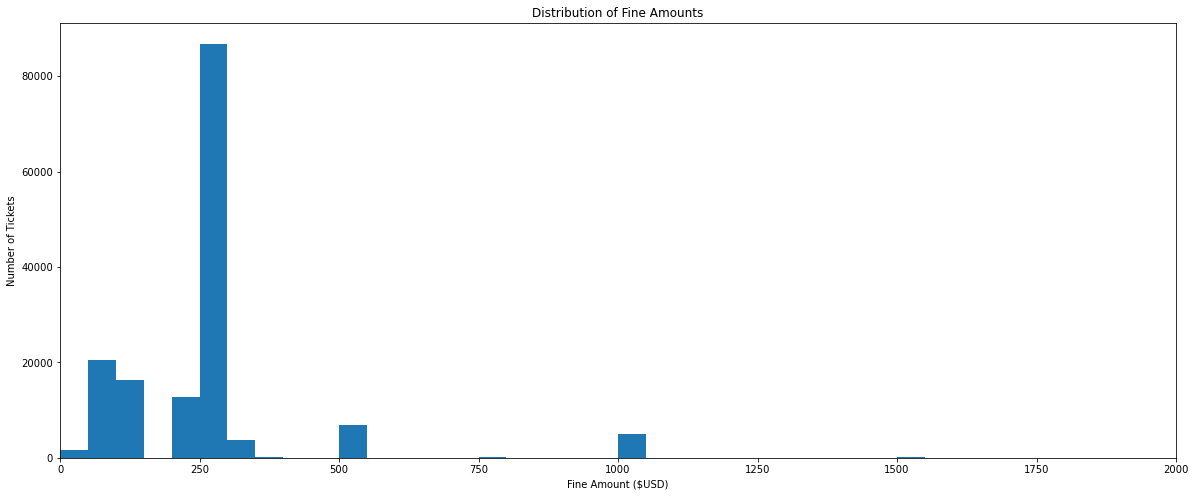

In [8]:
# Plot ticket
plt.figure(figsize=(20,8))
plt.xlim(0,2000)


plt.hist(past_tickets['fine_amount'], bins=200)

plt.title('Distribution of Fine Amounts')
plt.ylabel('Number of Tickets')
plt.xlabel('Fine Amount ($USD)')

In [9]:
past_tickets.columns

Index(['Unnamed: 0', 'ticket_id', 'agency_name', 'inspector_name',
       'violator_name', 'violation_street_number', 'violation_street_name',
       'violation_zip_code', 'mailing_address_str_number',
       'mailing_address_str_name', 'city', 'state', 'zip_code',
       'non_us_str_code', 'country', 'ticket_issued_date', 'hearing_date',
       'violation_code', 'violation_description', 'disposition', 'fine_amount',
       'admin_fee', 'state_fee', 'late_fee', 'discount_amount',
       'clean_up_cost', 'judgment_amount', 'payment_amount', 'balance_due',
       'payment_date', 'payment_status', 'collection_status',
       'grafitti_status', 'compliance_detail', 'compliance'],
      dtype='object')

In [10]:
current_tickets.columns

Index(['ticket_id', 'agency_name', 'inspector_name', 'violator_name',
       'violation_street_number', 'violation_street_name',
       'violation_zip_code', 'mailing_address_str_number',
       'mailing_address_str_name', 'city', 'state', 'zip_code',
       'non_us_str_code', 'country', 'ticket_issued_date', 'hearing_date',
       'violation_code', 'violation_description', 'disposition', 'fine_amount',
       'admin_fee', 'state_fee', 'late_fee', 'discount_amount',
       'clean_up_cost', 'judgment_amount', 'grafitti_status'],
      dtype='object')

# Cleaning the Data for Model Usage

In [11]:
def check_for_nas(data):
    copy = data.copy()
    
    for col in copy.columns:
        
        if copy[col].isnull().values.any():
            num_nas = len(copy[copy[col].isnull()])
            proportion_na = num_nas/len(copy[col])
            
            print('There are nulls in column:', col)
            print('The number of NAs is {}'.format(num_nas))
            print('The proportion of nas in {} is {}'.format(col, proportion_na), '\n')

In [12]:
check_for_nas(past_tickets)

There are nulls in column: violator_name
The number of NAs is 26
The proportion of nas in violator_name is 0.00016262196647485615 

There are nulls in column: violation_zip_code
The number of NAs is 159880
The proportion of nas in violation_zip_code is 1.0 

There are nulls in column: mailing_address_str_number
The number of NAs is 2558
The proportion of nas in mailing_address_str_number is 0.015999499624718538 

There are nulls in column: mailing_address_str_name
The number of NAs is 3
The proportion of nas in mailing_address_str_name is 1.8764073054791094e-05 

There are nulls in column: state
The number of NAs is 84
The proportion of nas in state is 0.0005253940455341507 

There are nulls in column: zip_code
The number of NAs is 1
The proportion of nas in zip_code is 6.254691018263698e-06 

There are nulls in column: non_us_str_code
The number of NAs is 159877
The proportion of nas in non_us_str_code is 0.9999812359269452 

There are nulls in column: hearing_date
The number of NAs i

In [13]:
check_for_nas(current_tickets)

There are nulls in column: violator_name
The number of NAs is 28
The proportion of nas in violator_name is 0.00045900886870707037 

There are nulls in column: violation_zip_code
The number of NAs is 36977
The proportion of nas in violation_zip_code is 0.6061703906493336 

There are nulls in column: mailing_address_str_number
The number of NAs is 1014
The proportion of nas in mailing_address_str_number is 0.016622678316748907 

There are nulls in column: mailing_address_str_name
The number of NAs is 3
The proportion of nas in mailing_address_str_name is 4.917952164718611e-05 

There are nulls in column: city
The number of NAs is 1
The proportion of nas in city is 1.639317388239537e-05 

There are nulls in column: state
The number of NAs is 331
The proportion of nas in state is 0.005426140555072867 

There are nulls in column: zip_code
The number of NAs is 3
The proportion of nas in zip_code is 4.917952164718611e-05 

There are nulls in column: non_us_str_code
The number of NAs is 61001


**Note on NA values**

We don't want to drop entire columns during training simply because of a few NA values.

We first check to see if our na values have a proportion of nas higher than na_floor. Then, based on the type of data in the field, we either fill it with the median value, or an empty string "". 

In [14]:
# Pull out columns with high proportion of NA values, turn text into float data, and typecast other fields to floats 

def numericize_or_drop_col(data, na_floor=0.01):
    
    dropped_cols = []
    copy = data.copy()
    
    for col in copy.columns:
        
        #print(col)
        
        if copy[col].isnull().values.any(): #Drops columns with too many NA values
            
            proportion_na = len(copy[copy[col].isnull()])/len(copy[col])
            
            if proportion_na > na_floor:
                dropped_cols.append((col, 'Too many NA values'))
                copy = copy.drop([col], axis=1)
                continue
                
            if type(copy[col][1] == str):
                copy[col] = copy[col].fillna('0')
                
            else:
                col_average = copy[col].mean()
                copy[col] = copy[col].fillna(col_average)
                
        
        if type(copy[col][1]) == str: #Turn string data into numerical for model
            #Sorts unique values of series by frequency and returns integers instead of strings 
            #Note: this is particularly useful for decision trees models that make binary splits
            
            dropped_cols.append((col, 'text to integers'))
            
            unique_series = copy[col].groupby(copy[col]).count()
            unique_series = unique_series.sort_values(ascending=False)
            text_to_int_dict = {unique_value:float(i) for i, unique_value in enumerate(unique_series.index)}
            copy['{}_as_float'.format(col)] = [text_to_int_dict[val] for val in copy.loc[:,col]].copy()

            copy = copy.drop([col], axis=1)
                  
                
        else: #typecast columns to floats
            #print('No nulls, moving on')
            copy[col] = copy[col].astype(np.float64)
                  
    #Make sure we didn't miss any NA values after process (debugging)
    check_for_nas(copy)
    
    return copy, dropped_cols

In [15]:
def numericize_or_drop_col(data, na_floor=0.01):
    dropped_cols = []
    copy = data.copy()
    for col in copy.columns:
        if copy[col].isnull().values.any(): #Drops columns with too many NA values
            proportion_na = len(copy[copy[col].isnull()])/len(copy[col])
            if proportion_na > na_floor:
                dropped_cols.append((col, 'Too many NA values'))
                copy = copy.drop([col], axis=1)
                continue
            if type(copy[col][1] == str):
                copy[col] = copy[col].fillna('0')
            else:
                col_average = copy[col].mean()
                copy[col] = copy[col].fillna(col_average)
        if type(copy[col][1]) == str: 
            dropped_cols.append((col, 'text to integers'))
            unique_series = copy[col].groupby(copy[col]).count()
            unique_series = unique_series.sort_values(ascending=False)
            text_to_int_dict = {unique_value:float(i) for i, unique_value in enumerate(unique_series.index)}
            copy['{}_as_float'.format(col)] = [text_to_int_dict[val] for val in copy.loc[:,col]].copy()
            copy = copy.drop([col], axis=1)    
        else:
            copy[col] = copy[col].astype(np.float64)
    return copy, dropped_cols

In [16]:
#Updating our training data for the model training 

new_past, past_dropped_cols = numericize_or_drop_col(past_tickets)
print('Dropped columns:\n', past_dropped_cols)
print('\n', 'New df columns')
print(new_past.columns)

Dropped columns:
 [('agency_name', 'text to integers'), ('inspector_name', 'text to integers'), ('violator_name', 'text to integers'), ('violation_street_name', 'text to integers'), ('violation_zip_code', 'Too many NA values'), ('mailing_address_str_number', 'Too many NA values'), ('mailing_address_str_name', 'text to integers'), ('city', 'text to integers'), ('state', 'text to integers'), ('zip_code', 'text to integers'), ('non_us_str_code', 'Too many NA values'), ('country', 'text to integers'), ('ticket_issued_date', 'text to integers'), ('hearing_date', 'text to integers'), ('violation_code', 'text to integers'), ('violation_description', 'text to integers'), ('disposition', 'text to integers'), ('payment_date', 'Too many NA values'), ('payment_status', 'text to integers'), ('collection_status', 'Too many NA values'), ('grafitti_status', 'Too many NA values'), ('compliance_detail', 'text to integers')]

 New df columns
Index(['Unnamed: 0', 'ticket_id', 'violation_street_number', 'f

In [17]:
#Updating our current_tickets data for model prediction use after training/testing

new_current, current_dropped_cols = numericize_or_drop_col(current_tickets)
print('Dropped columns:\n', current_dropped_cols)
print('\n', 'New df columns')
print(new_current.columns)

Dropped columns:
 [('agency_name', 'text to integers'), ('inspector_name', 'text to integers'), ('violator_name', 'text to integers'), ('violation_street_name', 'text to integers'), ('violation_zip_code', 'Too many NA values'), ('mailing_address_str_number', 'Too many NA values'), ('mailing_address_str_name', 'text to integers'), ('city', 'text to integers'), ('state', 'text to integers'), ('zip_code', 'text to integers'), ('non_us_str_code', 'Too many NA values'), ('country', 'text to integers'), ('ticket_issued_date', 'text to integers'), ('hearing_date', 'Too many NA values'), ('violation_code', 'text to integers'), ('violation_description', 'text to integers'), ('disposition', 'text to integers'), ('grafitti_status', 'Too many NA values')]

 New df columns
Index(['ticket_id', 'violation_street_number', 'fine_amount', 'admin_fee',
       'state_fee', 'late_fee', 'discount_amount', 'clean_up_cost',
       'judgment_amount', 'agency_name_as_float', 'inspector_name_as_float',
       'v

**Note on Data Leakage**

In our original past_tickets data and current_tickts data, columns appear in past_tickets that are not in current_tickets. In our model we don't want any data leakage during training, that is, we want to avoid training the model on fields that the testing set won't have. Because of this, we will drop any columns that are in the past_tickets data that are not in our current_tickets data.

In [18]:
print(target_variable)

compliance


In [19]:
new_current_col_set = set(new_current.columns.values) 
new_past_col_set = set(new_past.columns.values)

p_c_intersection = new_current_col_set.intersection(new_past_col_set)
p_c_union = new_current_col_set.union(new_past_col_set)

if p_c_union != p_c_intersection:
    print('There is Data Leakage')
    
    to_drop = p_c_union - p_c_intersection
    to_drop.remove(target_variable)

    print('Columns Dropped are:\n', to_drop)
    
    new_current = new_current[list(p_c_intersection)]
    p_c_intersection.add(target_variable)
    new_past = new_past[list(p_c_intersection)]
    

    
# Check for data leakage again (debug)
if set(new_past.columns.values) != set(new_past.columns.values):
    print('Still has data leakage')

There is Data Leakage
Columns Dropped are:
 {'compliance_detail_as_float', 'hearing_date_as_float', 'payment_amount', 'balance_due', 'Unnamed: 0', 'payment_status_as_float'}


In [20]:
# Many of these fields make sense in the context of our problem because current_tickets shouldn't contain fields related to 
# 'compliance' (our target variable)

# Building our Model
Here we will use three out of the box models: the Random Forest Classifier, Ridge Regression, and Multi-layer Perceptron Algorithms.


**Note on Normalization**

Two of our models will be more accurate if we normalize our data on a scale from 0 to 1, and the third model will be unaffected. Here we use sklearn's MeanMaxScaler fit on our training data to fit transform both our training and testing data.

In [21]:
# past_tickets Target Variable
y = new_past[target_variable]

# past_tickets without target variable
columns_minus_target = np.delete(new_past.columns.values, np.where(new_past.columns.values == target_variable))
X = new_past[columns_minus_target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)


scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
new_current_scaled = scaler.transform(new_current)

In [22]:
def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(np.arange(c_features), feature_names)

### Support Vector Machines Classifier
With Support Vector Machines, we decide to use GridSearchCV to find the best parameter for gamma and C. Grid search cross validation allows us to both look at overfitting and undefitting the data by adjusting our parameters while minimizing the variance between training runs. We find that C=0.01 and gamma=0.01 have the best accuracy on a partition of our data.
**Note on computation time**
The normal SVC takes a really long time to 

In [23]:
clf = SVC(kernel='rbf')

grid_values = {'C': [0.01, 0.05, 0.1, 1, 10, 100],
               'gamma': [0.01, 0.05, 0.1, 1, 10, 100]}

grid_clf_acc = GridSearchCV(clf, param_grid = grid_values)
grid_clf_acc.fit(X_train.iloc[:1000], y_train[:1000])
gridsvc = grid_clf_acc.best_params_

print('Grid best parameter (max. accuracy) for C: ', gridsvc['C'])
print('Grid best parameter (max. accuracy) for gamma: ', gridsvc['gamma'])
print('Grid best score (accuracy) for C: ', grid_clf_acc.best_score_)

#Grid Search for gamma
#grid_values = {'gamma': [0.01, 0.05, 0.1, 1, 10, 100]}

#grid_clf_acc = GridSearchCV(clf, param_grid = grid_values)
#grid_clf_acc.fit(X_train.iloc[:1000], y_train[:1000])
#best_gamma = grid_clf_acc.best_params_

#print('Grid best parameter (max. accuracy) for gamma: ', best_gamma)
#print('Grid best score (accuracy) for gamma: ', grid_clf_acc.best_score_)

Grid best parameter (max. accuracy) for C:  0.01
Grid best parameter (max. accuracy) for gamma:  0.01
Grid best score (accuracy) for C:  0.945


In [24]:
clf = SVC(kernel='rbf', C=gridsvc['C'], gamma=gridsvc['gamma']).fit(X_train[:1000], y_train[:1000])
print('Accuracy of RF classifier on training set: {:.3f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.3f}'
     .format(clf.score(X_test, y_test)))
print('Roc AUC score on data: {:.3f}'.format(roc_auc_score(y, clf.predict_proba(X)[:, 1])))

Accuracy of RF classifier on training set: 0.927
Accuracy of RF classifier on test set: 0.928


AttributeError: predict_proba is not available when  probability=False

In [ ]:
print(classification_report(y_test, clf.predict(X_test), target_names=['No Compliance', 'Compliance']))

In [ ]:
plt.figure(figsize=(10,4), dpi=80)
plot_feature_importances(clf, X_train.columns)
plt.show()

print('Feature importances: {}'.format(clf.feature_importances_))

### Random Forest Classifier
In this model, we use cross validation again, while using 10 trees for our CV and 150 trees for our model training to limit model computation time. From our CV, we find that our best max_features is ### and our best max_depth is ###, making sure that our training set is not too overfit, while still having a complex model.

In [ ]:
clf = RandomForestClassifier()

#Grid search for C
grid_values = {'max_features': [2, 5, 8, 12, 15, 20],
               'max_depth': [2, 5, 10, 15, 20, 25, 30]}

grid_clf_acc = GridSearchCV(clf, param_grid = grid_values)
grid_clf_acc.fit(X_train.iloc[:1000], y_train[:1000])
gridsvc = grid_clf_acc.best_params_

print('Grid best parameter (max. accuracy) for C: ', gridsvc['C'])
print('Grid best parameter (max. accuracy) for gamma: ', gridsvc['gamma'])
print('Grid best score (accuracy) for C: ', grid_clf_acc.best_score_)

In [54]:
# Random Forest Classifier
clf = RandomForestClassifier(n_estimators=150, max_features = 'auto', max_depth=25, random_state = 222).fit(X_train, y_train)
print('Accuracy of RF classifier on training set: {:.3f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.3f}'
     .format(clf.score(X_test, y_test)))
print('Roc AUC score on data: {:.3f}'.format(roc_auc_score(y, clf.predict_proba(X)[:, 1])))

Accuracy of RF classifier on training set: 0.983
Accuracy of RF classifier on test set: 0.946
Roc AUC score on data: 0.966


In [55]:
print(classification_report(y_test, clf.predict(X_test), target_names=['No Compliance', 'Compliance']))

               precision    recall  f1-score   support

No Compliance       0.95      1.00      0.97     48961
   Compliance       0.89      0.29      0.43      3800

     accuracy                           0.95     52761
    macro avg       0.92      0.64      0.70     52761
 weighted avg       0.94      0.95      0.93     52761



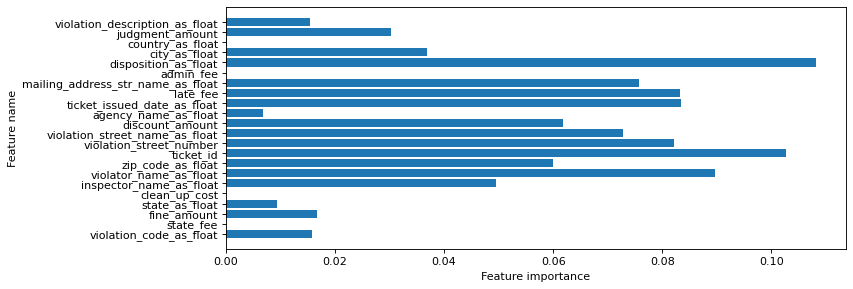

Feature importances: [0.0157767  0.         0.01669969 0.00940788 0.         0.0494628
 0.08964746 0.05988227 0.10261363 0.08205252 0.07280329 0.06187233
 0.00677202 0.08336106 0.08321596 0.07565463 0.         0.10824339
 0.03687022 0.00014081 0.03017871 0.01534461]


In [56]:
plt.figure(figsize=(10,4), dpi=80)
plot_feature_importances(clf, X_train.columns)
plt.show()

print('Feature importances: {}'.format(clf.feature_importances_))

### Multi-layer Perceptron Classifier

In [ ]:
MLPClassifier

# Model Evaluation

# Creating and Exporting Predictions